In [2]:
# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unets/unet_2d_condition.py
# https://cocalc.com/github/shivamshrirao/diffusers/blob/main/tests/test_ema.py
# https://github.com/fastai/course22p2/blob/master/nbs/20_DDIM.ipynb

In [2]:
import torchvision
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor, Pad
import matplotlib.pyplot as plt
import diffusers
from diffusers import UNet2DModel, UNet2DConditionModel, DDPMScheduler, DDPMPipeline, DDIMScheduler
from diffusers.optimization import get_scheduler
import torch.nn.functional as F
import torchvision.transforms.functional as TF

/home/bob/anaconda3/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [3]:
fashion_data_train = torchvision.datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transforms.Compose([Pad([2,2,2,2]), ToTensor()]))
fashion_data_test = torchvision.datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transforms.Compose([Pad([2,2,2,2]), ToTensor()]))

In [4]:
dl_train = torch.utils.data.DataLoader(fashion_data_train, batch_size=4, shuffle=True, num_workers=4)
dl_test = torch.utils.data.DataLoader(fashion_data_test, batch_size=4, shuffle=True, num_workers=4)

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


train_x, train_y = next(iter(dl_train))
def show_batch(train_x, train_y):
    figure = plt.figure()
    col, row = 4,train_x.shape[0]//4
    for i in range(row*col):
        idx = i
        img = train_x[idx]
        if train_y != None:
            label = train_y[idx].item()
        figure.add_subplot(row, col, i+1)
        if train_y != None:
            plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")

In [6]:
# create UNet2DConditionModel similar to UNet2DModel
unet = UNet2DConditionModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

In [7]:
device = "cuda"

max_steps = 2
lr = 1e-4
adam_beta1 = 0.95
adam_beta2 = 0.999
adam_weight_decay = 1e-6
adam_epsilon = 1e-08

dppm_timesteps = 1000
noise_scheduler = DDPMScheduler(num_train_timesteps=dppm_timesteps)

optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=lr,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

lr_scheduler = "cosine"
lr_warmup_steps = 500
gradient_accumulation_steps = 1
num_epochs = 10

# Initialize the learning rate scheduler
lr_scheduler = get_scheduler(
    lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps * gradient_accumulation_steps,
    num_training_steps=(len(dl_train) * num_epochs),
)

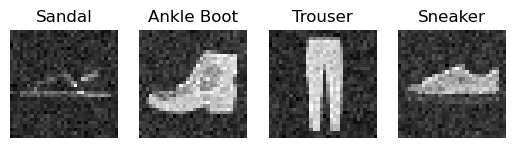

In [8]:
#noise to be added to the images
noise = torch.randn(train_x.shape)
batch_size = train_x.shape[0]

#random timestep for each image
#timesteps = torch.randint(0, dppm_timesteps, (batch_size,))
timesteps = torch.tensor(20)

#Add noise to input images to create noisy images, which is the actual inputs to the unet
noisy_images = noise_scheduler.add_noise(train_x, noise, timesteps)

show_batch(noisy_images, train_y)

In [9]:
encoder_hidden_states = torch.randn(4, 2, 1280)

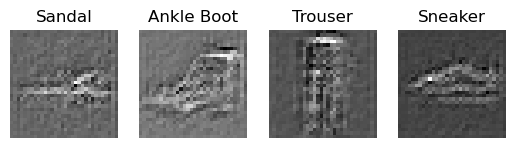

In [10]:
output = unet(noisy_images, timesteps, encoder_hidden_states).sample
show_batch(output.detach().numpy(), train_y)

In [11]:
# simple tokenizer (label index) and token embedding
# embedding size need to match cross_attention_dim which is default 1280
token_embedding_size = 1280
Emb = torch.nn.Embedding(len(labels_map),token_embedding_size)


In [12]:
def train():
    step = 1

    unet.to(device)
    unet.train()

    losses = 0
    for train_x, train_y in dl_train:

        train_x = (train_x-0.5).to(device)
        #noise to be added to the images
        noise = torch.randn(train_x.shape, device=device)
        
        batch_size = train_x.shape[0]

        
        #random timestep for each image
        timesteps = torch.randint(0, dppm_timesteps, (batch_size,), device=device)
        #Add noise to input images to create noisy images, which is the actual inputs to the unet
        noisy_images = noise_scheduler.add_noise(train_x, noise, timesteps).to(device)
        timesteps.to(device)

        # simple tokenizer (label index) and token embedding
        hidden = Emb(train_y[:,None]).to(device)
        
        # predict the noise
        output = unet(noisy_images, timesteps, hidden).sample
        
        loss = F.mse_loss(output, noise)
     
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        losses += loss.item()

        if step % 100 == 0:
            print(f'loss is {losses/100}')
            losses = 0        
        
        step+=1

In [45]:
num_epochs = 1
for _ in range(num_epochs):
    train()

loss is 0.8710010004043579
loss is 0.5183515757322311
loss is 0.2558678784966469
loss is 0.1446557554602623
loss is 0.11949987165629863
loss is 0.07401882752776145
loss is 0.08094845613464713
loss is 0.06856124088168145
loss is 0.05745330600067973
loss is 0.05159674252383411
loss is 0.04675248160026967
loss is 0.04597141823731363
loss is 0.05130758796818555
loss is 0.051278461879119275
loss is 0.04644564549438655
loss is 0.047096758112311364
loss is 0.045323066604323684
loss is 0.04015211111865938
loss is 0.03674784479197115
loss is 0.04506014716811478
loss is 0.038010253924876454
loss is 0.03385982682928443
loss is 0.03530863951891661
loss is 0.0331667627254501
loss is 0.03256103362422436
loss is 0.02589079851284623
loss is 0.040546326320618394
loss is 0.03516811630688608
loss is 0.03183932470623404
loss is 0.040659183491952716
loss is 0.03405094851274043
loss is 0.02874275458510965
loss is 0.03382632186170667
loss is 0.024532208556775004
loss is 0.026495442795567214
loss is 0.0399064

In [48]:
torch.save(unet, "unconditional01.pt")
torch.save(Emb, "unconditional_emb_01.pt")

In [13]:
unet = torch.load("unconditional01.pt")
Emb = torch.load("unconditional_emb_01.pt")

In [14]:
hidden = Emb(torch.tensor([0]*16)[:,None]).to(device)

@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model(x_t, t_batch, hidden).sample
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [15]:
from types import SimpleNamespace
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig
samples = sample(unet, (16, 1, 32, 32))

In [16]:
images=[samples[i][0] for i in list(range(849, 1001, 10))]

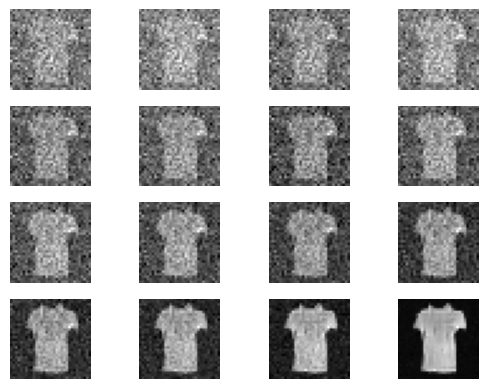

In [26]:
show_batch(torch.cat(images),None)

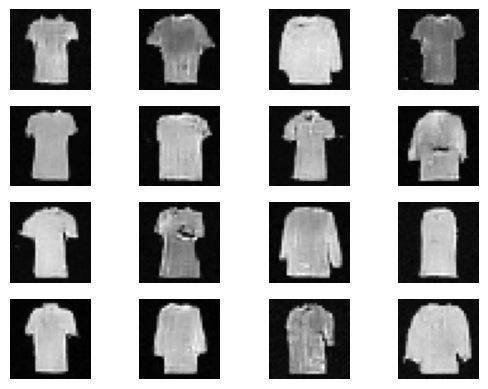

In [27]:
show_batch(samples[-1],None)

In [28]:
hidden = Emb(torch.tensor([0]*16)[:,None]).to(device)

In [29]:
from fastprogress.fastprogress import progress_bar

sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(20)
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t, hidden).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds
sz = (16,1,32,32)
preds = diff_sample(unet, sz, sched, eta=1.)

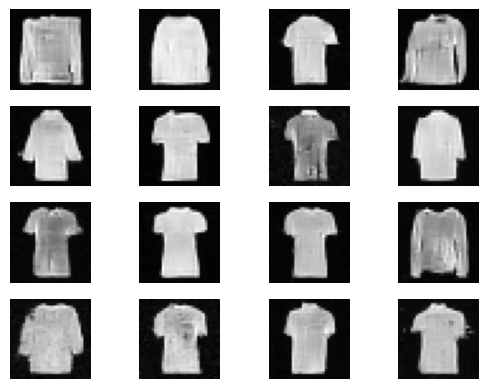

In [30]:
show_batch(preds[-1],None)